In [1]:
import numpy as np
import scipy
from scipy import sparse as sp
from scipy.sparse import csr_matrix as csr
from numpy import matlib
from scipy import linalg
from scipy.special import binom as newton
from scipy.stats import norm
from scipy.special import hermitenorm as hermite
from itertools import permutations 
import math
import timeit, time
import matplotlib.pyplot as plt
from scipy.integrate import nquad, quad
np.set_printoptions(precision = 5, suppress = True, linewidth = 100)

In [4]:
def meanX(m, time_sequence):
    mean_sum = 0
    for j in range(m+1):
        sj = time_sequence[j]
        mean_sum += initial_state*np.exp(b1*(sj-t)) + b0*(np.exp(b1*(sj-t))-1)/b1
    return mean_sum/(m+1)


def varX(m, b1, sigma0, time_sequence, t=0):
    ts = np.append(t, time_sequence)
    var_sum = 0
    for j in range(m+1):
        for k1 in range(j, m+1):
            for k2 in range(j, m+1):
                var_sum += np.exp(b1*(ts[k1+1]+ts[k2+1]-2*ts[j]))-np.exp(b1*(ts[k1+1]+ts[k2+1]-2*ts[j+1]))
    return np.sqrt(sigma0*var_sum/(2*b1*(m+1)**2))

In [5]:
m = 0 # number of polynomials -1 (i.e. the total number is m+1)

r = 0.02
t = 0
T = float(1/2)
time_sequence = np.linspace(t, T, m+2)[1:]
initial_state = 5.0

K = initial_state
b1 = 0.01
b0 = -K*b1
ts = np.append(t, time_sequence)
var_sum = 0
for j in range(m+1):
    for k1 in range(j, m+1):
        for k2 in range(j, m+1):
            var_sum += (np.exp(b1*(ts[k1+1]+ts[k2+1]-2*ts[j]))-np.exp(b1*(ts[k1+1]+ts[k2+1]-2*ts[j+1])))
sigma0 = 2*b1*(m+1)**2/var_sum

mean = meanX(m, time_sequence)
std = varX(m, b1, sigma0, time_sequence, t)

print('mean = ', mean)
print('std = ', std)

mean =  5.0
std =  1.0


In [6]:
def phi(x, K):
    return (x-K>=0)*(x-K)

In [7]:
def phi_hat_ab(x, a, b, K, N):
    nn = len(x)
    ratio = (K-a)/b
    phi_hat_vector = b*np.ones((N+1, nn))*norm.pdf(ratio)
    phi_hat_vector[1:, :] += (x-K)*(1-norm.cdf(ratio))
    hermite_old = hermite(1)
    hermite_old_old = hermite(0)
    for n in range(2,N+1):
        #print(n)
        hermite_new = hermite(n)
        phi_hat_vector[n:, :] += b*norm.pdf(ratio)*hermite_old_old(ratio)*hermite_new((x-a)/b)/float(math.factorial(n))
        hermite_old_old = hermite_old
        hermite_old = hermite_new
    return phi_hat_vector

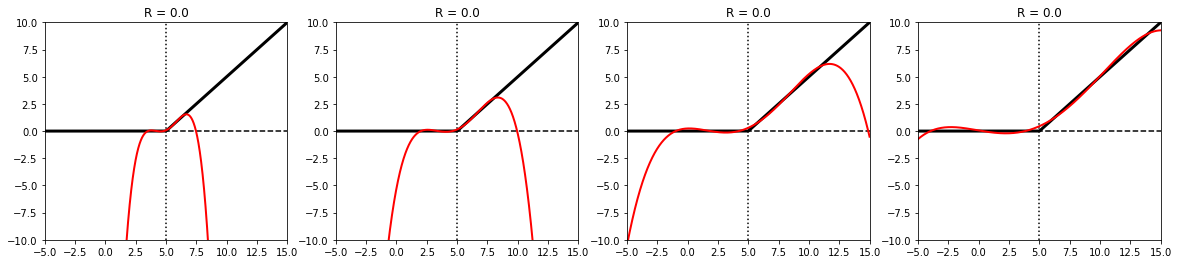

In [8]:
K = mean
N = 5
a_vec = np.array([1, 1, 1, 1])
b_vec = np.array([0.5, 1.0, 2, 3])
K_vec = np.array([1, 1, 1, 1])
f = plt.figure(figsize = (20,4))
for i in range(4):
    y = np.linspace(K_vec[i]*K-10,K_vec[i]*K+10,2000)
    plt.subplot(1,4,i+1)
    plt.axvline(x = mean, color='k', linestyle=':')
    plt.axhline(y = 0, color='k', linestyle='--');
    
    plt.plot(y, phi(y, K_vec[i]*K), 'k', linewidth = 3)
    
    plt.plot(y, phi_hat_ab(y, a_vec[i]*K, b_vec[i]*std, K_vec[i]*K, N)[N,:], 'r-', linewidth = 2)
    
    plt.xlim([K_vec[i]*K-10,K_vec[i]*K+10]);
    plt.ylim([-10, 10]);
    string = 'R = {}'
    plt.title(string.format((K_vec[i]*K-a_vec[i]*mean)/(b_vec[i]*std)))
#f.savefig('Hermite50.pdf', bbox_inches = 'tight', pad_inches = 0.01)

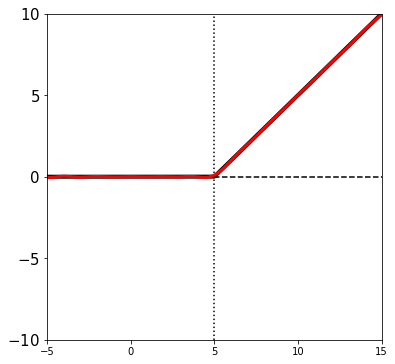

In [9]:
K = 5
N = 100
a_vec = np.array([1, 1, 1, 1])
b_vec = np.array([0.5, 1.0, 2, 3])
K_vec = np.array([1, 1, 1, 1])
f = plt.figure(figsize = (6,6))

i = 3
y = np.linspace(K_vec[i]*K-10,K_vec[i]*K+10,2000)
plt.axvline(x = mean, color='k', linestyle=':')
plt.axhline(y = 0, color='k', linestyle='--');
plt.plot(y, phi(y, K_vec[i]*K), 'k', linewidth = 4)
plt.plot(y, phi_hat_ab(y, a_vec[i]*K, b_vec[i]*std, K_vec[i]*K, N)[N,:], 'r-', linewidth = 3)
plt.xlim([K_vec[i]*K-10,K_vec[i]*K+10]);
plt.xlim([K_vec[i]*K-10,K_vec[i]*K+10]);
plt.yticks(np.array([-10, -5, 0, 5, 10]), labels = ["$-10$", "$-5$", "$0$", "$5$", "$10$"], fontsize=15)
plt.ylim([-10, 10]);
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
#f.savefig('Hermite100_3.pdf', bbox_inches = 'tight', pad_inches = 0.01)

In [12]:
def err_phi_hat_ab(a, b, K):
    M = 160
    N_max = 100
    ratio = (K-a)/b
    err_phi_hat_vector = np.zeros(N_max-1)
    for n in range(2, N_max+1):
        for k in range(n+1, M):
            err_phi_hat_vector[n-2] += (hermite(k-2)(ratio)/float(math.factorial(k)))**2
    return b*norm.pdf(ratio)*np.sqrt(err_phi_hat_vector)

In [13]:
b_range = np.array([0.5, 1.0, 2.0, 3.0, 6.0, 10.0]) 
err_log = np.zeros((99, len(b_range)))
i = 0
for b in b_range:
    err_log[:,i] = err_phi_hat_ab(5, b, 5)
    i = i+1


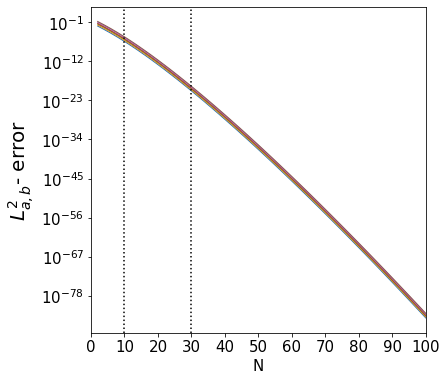

In [14]:
f = plt.figure(figsize = (6,6))
plt.semilogy(np.arange(2,101,2), err_log[::2], linewidth = 1.0)
plt.xlim([0,100]);
plt.xlabel('N', fontsize=15)
plt.ylabel('$L^2_{a,b}$- error', fontsize=20)
plt.axvline(x = 10, color='k', linestyle=':')
plt.axvline(x = 30, color='k', linestyle=':')
plt.yticks(fontsize=15)
plt.xticks(np.arange(0,103,10), np.arange(0,103,10), fontsize=15);
#plt.legend(['b = 0.2', 'b = 0.5', 'b = 1.0', 'b = 2.0', 'b = 3.0', 'b = 6.0'], fontsize=15);
#f.savefig('Plots_approx_error/approx_err_100_3rd.pdf', bbox_inches = 'tight', pad_inches = 0.01)

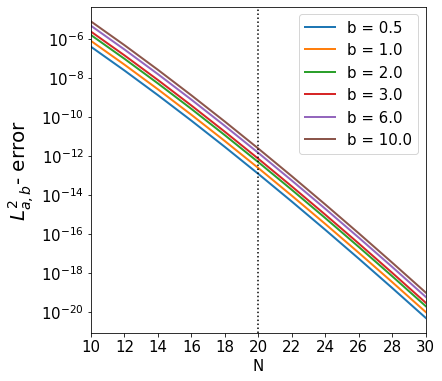

In [15]:
f = plt.figure(figsize = (6,6))
power = -25.0
plt.semilogy(np.arange(10,31,2), err_log[9:30:2,:], linewidth = 2)
#plt.semilogy(np.arange(10,31,2), np.arange(10,31,2)**power/(10**power)*err_log[9,2], 'k',linewidth = 2)
plt.xlim([10,30]);
#plt.ylim([np.min(err[11:30,:])-0.2, np.max(err[11:30,:])+0.2])
plt.xlabel('N', fontsize=15)
plt.ylabel('$L^2_{a,b}$- error', fontsize=20)
plt.axvline(x = 20, color='k', linestyle=':')
plt.yticks(fontsize=15)
plt.xticks(np.arange(10,32,2), np.arange(10,32,2), fontsize=15);
plt.legend(['b = 0.5', 'b = 1.0', 'b = 2.0', 'b = 3.0', 'b = 6.0', 'b = 10.0'], fontsize=15);
#f.savefig('Plots_approx_error/approx_err_20_3rd.pdf', bbox_inches = 'tight', pad_inches = 0.01)

In [16]:
def err_phi_hat_ab2(a, b, K):
    M = 160
    N_max = 20
    ratio = (K-a)/b
    err_phi_hat_vector = 0
    for n in range(N_max+1, M):
        err_phi_hat_vector += (hermite(n-2)(ratio)/float(math.factorial(n)))**2
    return b*norm.pdf(ratio)*np.sqrt(err_phi_hat_vector)

In [17]:
b_range2 = np.linspace(0.5, 10.0, num = 50)
err2 = np.zeros(len(b_range2))
i = 0
for b in b_range2:
    err2[i] = err_phi_hat_ab2(10, b, 5)
    print(err2[i])
    i = i+1


9.364618249184738e-25
1.1259772493286487e-18
3.7185057708009995e-16
3.6810898245307035e-15
2.854518590863924e-14
8.677740874093702e-14
9.506602823661497e-14
2.7990393286052115e-13
5.121698135574203e-13
2.659972753424278e-13
4.788046529460295e-13
1.127947002459463e-12
1.5065599923690939e-12
1.489800601834407e-12
1.1179257204905758e-12
5.860595487442241e-13
6.935799595251852e-13
1.4463908541170954e-12
2.2349218166893053e-12
2.935912169482856e-12
3.5047880557528587e-12
3.923729585277451e-12
4.190379099842846e-12
4.311968045133783e-12
4.301428926288707e-12
4.17477817877551e-12
3.949461203375654e-12
3.6434816453402395e-12
3.2752632261271545e-12
2.8644046525304065e-12
2.433927882958435e-12
2.015540664638977e-12
1.6604321908237683e-12
1.4513760102404474e-12
1.4747516814899061e-12
1.7311090495677066e-12
2.140565032329789e-12
2.6308007708094542e-12
3.160579209172232e-12
3.7081637122035385e-12
4.261558175659466e-12
4.813670763339784e-12
5.360052783342425e-12
5.89779442901819e-12
6.42494727204196

In [18]:
def coeffh(b):
    K = 5
    a = 10
    ratio = (K-a)/b
    return b*norm.pdf(ratio)

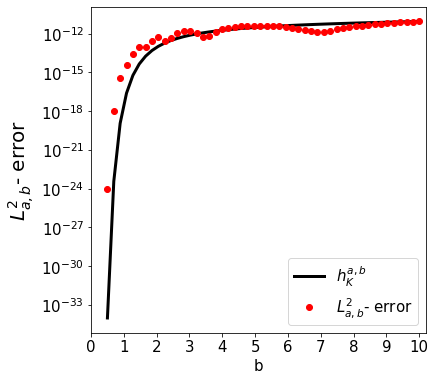

In [19]:
f = plt.figure(figsize = (6,6))
plt.semilogy(b_range2, coeffh(b_range2)/coeffh(b_range2[-1])*err2[-1], 'k-',linewidth = 3.0)
plt.semilogy(b_range2, err2, 'ro',linewidth = 1.0)
plt.xlim([0,10.2]);
plt.xlabel('b', fontsize=15)
plt.ylabel('$L^2_{a,b}$- error', fontsize=20);
plt.yticks(fontsize=15)
plt.xticks(np.arange(0,11), np.arange(0,11), fontsize=15);
plt.legend(['$h_K^{a,b}$', '$L^2_{a,b}$- error'], fontsize=15);
#f.savefig('Plots_approx_error/approx_err_curve_3rd.pdf', bbox_inches = 'tight', pad_inches = 0.01)